#### RNA (Redes Neuronales Artificiales): 
# **TITANIC —> MLPClassifier**

##### **Importar librerías y configuración general**

In [1]:
import warnings
warnings.filterwarnings("ignore")  # Para ocultar warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Para preprocesamiento y creación de variables dummy
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Para modelar
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder

# Árbol de decisión para imputar 'Embarked' o 'Age' 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# Multi-Layer Perceptron
from sklearn.neural_network import MLPClassifier

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

import multiprocessing

# Semilla para reproducibilidad
np.random.seed(123)

print("Librerías importadas y configuración lista.")


Librerías importadas y configuración lista.


##### **Cargar datos y Exploración inicial**

In [2]:
# Cargar train y test (asegurase de que los archivos estén en el mismo directorio o usar rutas adecuadas)
train = pd.read_csv("data/titanic/train.csv", sep=",")
test = pd.read_csv("data/titanic/test.csv", sep=",")

# Visualizar primeras filas
display(train.head())
display(test.head())

# Resumen rápido de las variables
print(train.info())
print(test.info())

# Añadir la columna 'Survived' al conjunto de test (con NA/None) para luego unificarlos
test['Survived'] = np.nan

# Combinar los datasets
full_data = pd.concat([train, test], axis=0, ignore_index=True)

print("Dimensiones de full_data:", full_data.shape)
full_data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### **Feature Engineering**

In [5]:
# --- 3.1 Extraer títulos de los nombres ---
full_data['Title'] = full_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

# Agrupar títulos poco comunes
rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
full_data['Title'] = full_data['Title'].replace(rare_titles, 'Rare')
full_data['Title'] = full_data['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs'})

# Convertir a categoría
full_data['Title'] = full_data['Title'].astype('category')

# --- 3.2 Crear variable 'FamilySize' ---
full_data['FamilySize'] = full_data['SibSp'] + full_data['Parch'] + 1

# --- 3.3 Crear variable 'IsAlone' ---
full_data['IsAlone'] = (full_data['FamilySize'] == 1).astype(int)

# --- 3.4 Imputar 'Embarked' con un árbol de decisión ---

# Verificar valores faltantes en 'Embarked'
print("Valores faltantes en 'Embarked':", full_data['Embarked'].isnull().sum())

# Separar datos con y sin 'Embarked'
embarked_not_null = full_data[full_data['Embarked'].notnull()].copy()
embarked_null     = full_data[full_data['Embarked'].isnull()].copy()

features_embarked = ['Pclass','Sex','Fare','Age','Title','FamilySize']

# 1) Crear un diccionario de LabelEncoders para las columnas categóricas
label_encoders = {}

for col in ['Sex', 'Title']:
    le = LabelEncoder()
    
    # Usamos los datos de embarked_not_null para 'entrenar' (fit) el encoder,
    # asegurándonos de convertir NaN (si existiera) a alguna categoría. 
    embarked_not_null[col] = embarked_not_null[col].fillna('Rare').astype(str)
    le.fit(embarked_not_null[col])  
    
    # Transformamos la columna de embarked_not_null
    embarked_not_null[col] = le.transform(embarked_not_null[col])
    
    # Guardamos este encoder para reutilizarlo en embarked_null
    label_encoders[col] = le

# 2) Ajustar un árbol de decisión para predecir 'Embarked'
embarked_tree = DecisionTreeClassifier(random_state=123)
embarked_tree.fit(embarked_not_null[features_embarked], embarked_not_null['Embarked'])

# 3) Transformar las columnas de embarked_null con los mismos label encoders
for col in ['Sex', 'Title']:
    embarked_null[col] = embarked_null[col].fillna('Rare').astype(str)
    embarked_null[col] = label_encoders[col].transform(embarked_null[col])

# 4) Predecir los valores de 'Embarked' faltantes
pred_embarked = embarked_tree.predict(embarked_null[features_embarked])
full_data.loc[full_data['Embarked'].isnull(), 'Embarked'] = pred_embarked

# Asegurarnos de que 'Embarked' sea categoría
full_data['Embarked'] = full_data['Embarked'].astype('category')

# --- 3.5 Rellenar valores faltantes en 'Fare' con la mediana ---
full_data['Fare'] = full_data['Fare'].fillna(full_data['Fare'].median())

# --- 3.6 Eliminar variables no relevantes ---
full_data.drop(columns=['Name','Ticket','Cabin','PassengerId'], inplace=True, errors='ignore')

# --- 3.7 Imputar 'Age' con la mediana (simplificado) ---
full_data['Age'] = full_data['Age'].fillna(full_data['Age'].median())

# Verificar nulos finales
print("\nValores faltantes finales:\n", full_data.isnull().sum())
print("Feature engineering completado.")


Valores faltantes en 'Embarked': 2

Valores faltantes finales:
 Survived      418
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
Title           0
FamilySize      0
IsAlone         0
dtype: int64
Feature engineering completado.


##### **División en train/test tras transformación**

In [6]:
# Recordemos que el train original tenía nrows = train.shape[0]
n_train = train.shape[0]

# Reconstruimos train_data y test_data
train_data = full_data.iloc[:n_train, :].copy()
test_data  = full_data.iloc[n_train:, :].copy()

# Comprobamos
print("Dimensiones train_data:", train_data.shape)
print("Dimensiones test_data :", test_data.shape)

# Retiramos las filas con Survived = NA en test_data (o las conservamos para submission)
# Observamos si Survived está en train_data:
print(train_data['Survived'].value_counts(dropna=False))

# Convertir Survived a entero para clasificación
train_data['Survived'] = train_data['Survived'].astype(int)


Dimensiones train_data: (891, 11)
Dimensiones test_data : (418, 11)
Survived
0.0    549
1.0    342
Name: count, dtype: int64


##### **Definir X, y para el entrenamiento y validación**

In [7]:
# Variables predictoras
features = list(train_data.columns)
features.remove('Survived')  # remove la columna Survived

X = train_data[features].copy()
y = train_data['Survived'].copy()

print("Tamaño de X:", X.shape)
print("Tamaño de y:", y.shape)

# Codificar variables categóricas (Pclass, Sex, Embarked, Title...) -> OneHotEncoder o pd.get_dummies
X_dummies = pd.get_dummies(X, drop_first=False)
print("Tamaño X_dummies:", X_dummies.shape)

# Para test
X_test = test_data[features].copy()
X_test_dummies = pd.get_dummies(X_test, drop_first=False)

# Asegurarnos de que X_dummies y X_test_dummies tengan las mismas columnas
X_test_dummies = X_test_dummies.reindex(columns = X_dummies.columns, fill_value=0)


Tamaño de X: (891, 10)
Tamaño de y: (891,)
Tamaño X_dummies: (891, 18)


##### **Entrenamiento de 4 modelos MLP manuales con distintas capas**

In [8]:
from sklearn.model_selection import cross_val_score

# 4 modelos con distintas capas
modelo_1 = MLPClassifier(
    hidden_layer_sizes=(5,),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter=1000,
    random_state=123
)

modelo_2 = MLPClassifier(
    hidden_layer_sizes=(10,),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter=1000,
    random_state=123
)

modelo_3 = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter=5000,
    random_state=123
)

modelo_4 = MLPClassifier(
    hidden_layer_sizes=(50, 50, 50),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter=5000,
    random_state=123
)

modelos = [modelo_1, modelo_2, modelo_3, modelo_4]

for i, m in enumerate(modelos, 1):
    # Entrenamos con cross-validation para ver su rendimiento
    scores = cross_val_score(m, X_dummies, y, cv=5, scoring='accuracy')
    print(f"Modelo {i} - capas {m.hidden_layer_sizes}:")
    print(f"  Accuracy CV (media ± std): {scores.mean():.4f} ± {scores.std():.4f}")


Modelo 1 - capas (5,):
  Accuracy CV (media ± std): 0.8193 ± 0.0295
Modelo 2 - capas (10,):
  Accuracy CV (media ± std): 0.8137 ± 0.0264
Modelo 3 - capas (20, 20):
  Accuracy CV (media ± std): 0.7868 ± 0.0238
Modelo 4 - capas (50, 50, 50):
  Accuracy CV (media ± std): 0.7879 ± 0.0171


##### **GridSearch para hidden_layer_sizes**

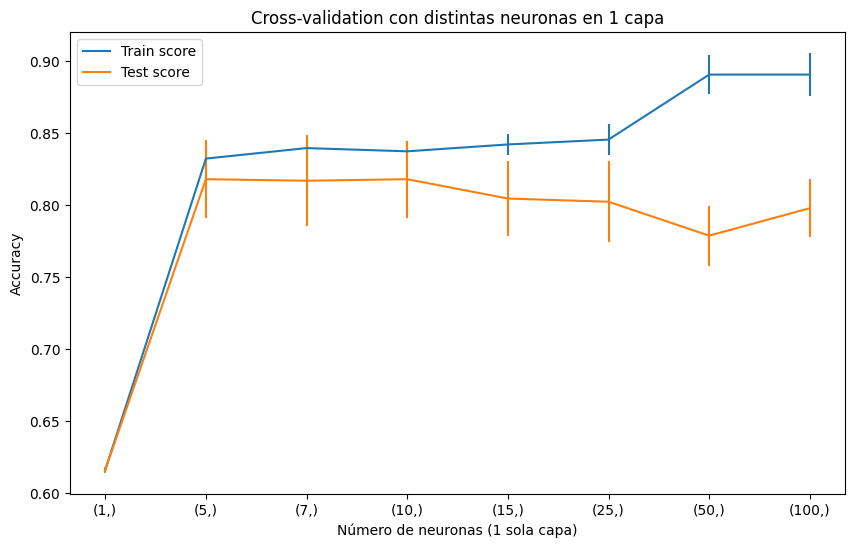

Mejores parámetros: {'hidden_layer_sizes': (5,)}
Mejor accuracy en validación: 0.8181846713953925


In [9]:
param_grid = {'hidden_layer_sizes': [ (1,), (5,), (7,), (10,), (15,), (25,), (50,), (100,) ]}

grid = GridSearchCV(
    estimator=MLPClassifier(
        learning_rate_init=0.01,
        solver='lbfgs',
        alpha=0,
        max_iter=5000,
        random_state=123
    ),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    refit=True,
    return_train_score=True
)

grid.fit(X_dummies, y)

# Gráfico
scores = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(1,1, figsize=(10, 6))
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax, label='Train score')
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score',  yerr='std_test_score',  ax=ax, label='Test score')
ax.set_xlabel('Número de neuronas (1 sola capa)')
ax.set_ylabel('Accuracy')
ax.set_title('Cross-validation con distintas neuronas en 1 capa')
plt.show()

print("Mejores parámetros:", grid.best_params_)
print("Mejor accuracy en validación:", grid.best_score_)


##### **GridSearch para learning_rate_init**

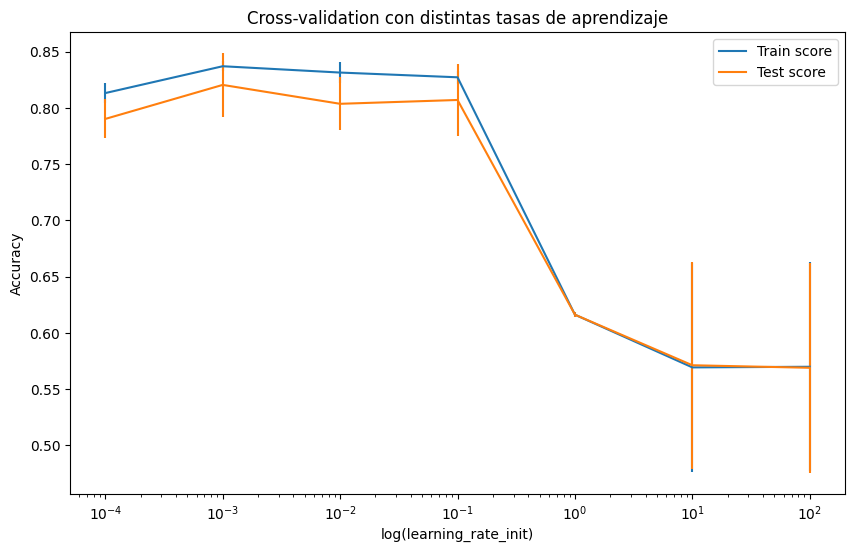

Mejores parámetros: {'learning_rate_init': 0.001}
Mejor accuracy en validación: 0.8203941999874459


In [10]:
param_grid_lr = {
    'learning_rate_init': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

grid_lr = GridSearchCV(
    estimator=MLPClassifier(
        hidden_layer_sizes=(10,),
        solver='adam',
        alpha=0,
        max_iter=5000,
        random_state=123
    ),
    param_grid=param_grid_lr,
    scoring='accuracy',
    cv=5,
    refit=True,
    return_train_score=True
)

grid_lr.fit(X_dummies, y)

scores_lr = pd.DataFrame(grid_lr.cv_results_)

fig, ax = plt.subplots(1,1, figsize=(10, 6))
scores_lr.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax, label='Train score')
scores_lr.plot(x='param_learning_rate_init', y='mean_test_score',  yerr='std_test_score',  ax=ax, label='Test score')
ax.set_xscale('log')  # escala logarítmica
ax.set_xlabel('log(learning_rate_init)')
ax.set_ylabel('Accuracy')
ax.set_title('Cross-validation con distintas tasas de aprendizaje')
plt.show()

print("Mejores parámetros:", grid_lr.best_params_)
print("Mejor accuracy en validación:", grid_lr.best_score_)


##### **Búsqueda aleatoria con RandomizedSearchCV**

In [11]:
from scipy.stats import loguniform

# Definimos distribuciones
param_distributions = {
    'hidden_layer_sizes': [(10,), (10, 10), (20, 20), (50, 50)],
    'alpha': np.logspace(-3, 3, 7),            # [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
    'learning_rate_init': [0.001, 0.01, 0.1]
}

random_search = RandomizedSearchCV(
    estimator=MLPClassifier(solver='lbfgs', max_iter=5000, random_state=123),
    param_distributions=param_distributions,
    n_iter=20,  # número de combinaciones a probar
    scoring='accuracy',
    n_jobs=multiprocessing.cpu_count() - 1,
    cv=3,
    verbose=0,
    random_state=123,
    return_train_score=True
)

random_search.fit(X_dummies, y)

resultados = pd.DataFrame(random_search.cv_results_)

# Mostramos top 10 resultados
print(resultados.filter(regex='(param.*|mean_t|std_t)').drop(columns='params')
      .sort_values('mean_test_score', ascending=False)
      .head(10))

print("\nMejores hiperparámetros encontrados:\n", random_search.best_params_)
print("Mejor score de validación:", random_search.best_score_)

# Modelo final
modelo_final = random_search.best_estimator_

# Métricas en training con cross_val
acc_cv = cross_val_score(modelo_final, X_dummies, y, cv=5, scoring='accuracy')
print(f"\nAccuracy CV (Media ± STD): {acc_cv.mean():.4f} ± {acc_cv.std():.4f}")


/Users/egoitzaulestiapadilla/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


    param_learning_rate_init param_hidden_layer_sizes  param_alpha  \
16                     0.001                    (10,)        0.100   
7                      0.010                    (10,)        1.000   
18                     0.100                    (10,)       10.000   
14                     0.100                 (20, 20)       10.000   
13                     0.001                 (10, 10)       10.000   
2                      0.010                 (10, 10)        0.001   
12                     0.001                 (50, 50)        0.001   
11                     0.001                 (50, 50)        1.000   
17                     0.010                 (20, 20)        0.010   
8                      0.010                 (20, 20)        0.100   

    mean_test_score  std_test_score  mean_train_score  std_train_score  
16         0.815937        0.016109          0.838384         0.010378  
7          0.813692        0.020634          0.839506         0.006496  
18        

##### **Evaluación final y Predicciones en Test**

In [24]:
# Entrenar el modelo_final con TODOS los datos de train
modelo_final.fit(X_dummies, y)

# Predicciones finales en test
test_pred = modelo_final.predict(X_test_dummies)

original_test = pd.read_csv("data/titanic/test.csv", sep=",")
submission = pd.DataFrame({
    'PassengerId': original_test['PassengerId'],
    'Survived': test_pred.astype(int)
})

submission.head()

# Guardar CSV final
submission.to_csv("data/submissions/titanic_MLPClassifier/submission_MLP_Modelo_3.csv", index=False)
print("Archivo de submission guardado: submission_MLP.csv")


Archivo de submission guardado: submission_MLP.csv


In [23]:
# 4 modelos con distintas capas
modelo_final = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    learning_rate_init=0.01,
    solver='lbfgs',
    max_iter=5000,
    random_state=123
)